In [1]:
from agricultural_csp.instance import *
from agricultural_csp.evaluator import *
from agricultural_csp.solver.agcsp_ts import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
def display_grid_and_path(inst, evaluator, path):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = inst.target_node_count
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f" - {len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    if len(path) > 0:
        path_arr = np.array(path)
        plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
                label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
                markeredgecolor='#9900CC', markeredgewidth=2)
    
    # Plot start point (green star)
    if len(path) > 0:
        plt.scatter(path_arr[0, 0], path_arr[0, 1], c='#00DD00', s=200, 
                   marker='*', label='Start', edgecolors='black', linewidths=2, zorder=5)
    
    # Plot end point (red square)
    if len(path) > 1:
        plt.scatter(path_arr[-1, 0], path_arr[-1, 1], c='#DD0000', s=100, 
                   marker='s', label='End', edgecolors='black', linewidths=2, zorder=5)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

In [3]:
min_coord_trabalho = 0
max_coord_trabalho = 49

min_coord_total = min_coord_trabalho - 1
max_coord_total = max_coord_trabalho + 1

r_grid, c_grid = np.mgrid[min_coord_total:max_coord_total+1, 
                            min_coord_total:max_coord_total+1]

grid_nodes_total = np.vstack([r_grid.ravel(), c_grid.ravel()]).T

obstacle_half_size = 2
obstacle_positions = [
    (10, 10), (10, 40), (25, 25), (40, 10), (40, 40)
]

obstacle_list = []
for obs_r, obs_c in obstacle_positions:
    mask_interna = (np.abs(r_grid - obs_r) <= obstacle_half_size) & \
                   (np.abs(c_grid - obs_c) <= obstacle_half_size)
    
    obstacle_list.append(grid_nodes_total[mask_interna.ravel()])

internal_obstacle_nodes = np.vstack(obstacle_list)

border_mask = (r_grid == min_coord_total) | (r_grid == max_coord_total) | \
              (c_grid == min_coord_total) | (c_grid == max_coord_total)
              
border_nodes = grid_nodes_total[border_mask.ravel()]

obstacle_nodes = np.vstack([internal_obstacle_nodes, border_nodes])

obstacle_nodes = np.unique(obstacle_nodes, axis=0)

instance = AgcspInstance(grid_nodes_total, obstacle_nodes, 
                         sprayer_length=5, 
                         max_turn_angle=90, 
                         adaptive_sampling=True)



""" instance = AgcspInstance(grid_nodes, np.array([]), 5, 90) """
evaluator = AgcspEvaluator(instance)


Grid Adaptativo: Densidade original (2704)
Grid Adaptativo: Nova densidade (reduzida) (1684 nós)


Coverage: 0/2371 nodes (0.0%)
Obstacles: 0/333 covered


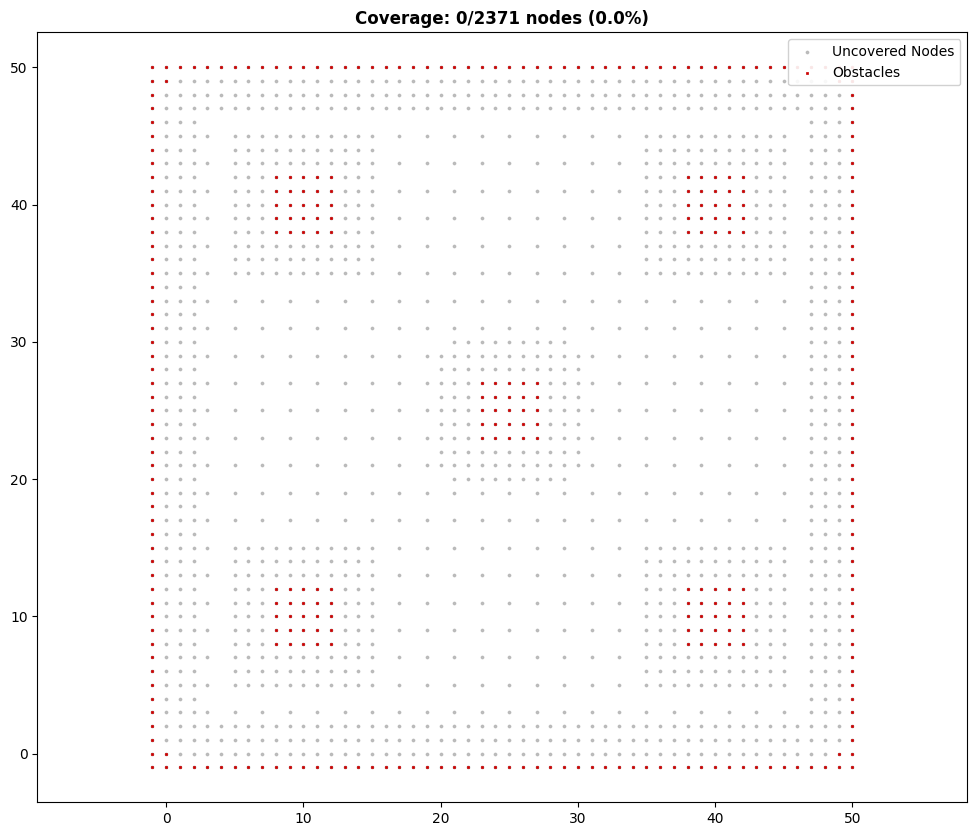

In [4]:
display_grid_and_path(inst=instance, evaluator=evaluator, path=[])

In [5]:
strategy = TSStrategy(
    constructive_heuristic=ConstructiveHeuristicType.FSM_COVERAGE_PLANNER,
    phased_optimization=PhasedOptimizationParams(phase_iterations=[2, 10, 5], degradation_tolerances=[0.0, 0.0, 0.0]),
    tabu_radius=3,
    search_strategy='first'
)

term_criteria = TerminationCriteria(max_iterations=200)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

  Visitou (np.int64(2), np.int64(2)), cobriu 7 novos nós. 1723 restantes.
Heurística 'Set Cover': Iniciando. 1723 alvos restantes.
  Visitou (np.int64(4), np.int64(4)), cobriu 14 novos nós. 1709 restantes.
  Visitou (np.int64(7), np.int64(4)), cobriu 13 novos nós. 1696 restantes.
  Visitou (np.int64(10), np.int64(4)), cobriu 12 novos nós. 1684 restantes.
  Visitou (np.int64(13), np.int64(4)), cobriu 13 novos nós. 1671 restantes.
  Visitou (np.int64(16), np.int64(4)), cobriu 15 novos nós. 1656 restantes.
  Visitou (np.int64(19), np.int64(4)), cobriu 15 novos nós. 1641 restantes.
  Visitou (np.int64(22), np.int64(4)), cobriu 15 novos nós. 1626 restantes.
  Visitou (np.int64(25), np.int64(4)), cobriu 15 novos nós. 1611 restantes.
  Visitou (np.int64(28), np.int64(4)), cobriu 15 novos nós. 1596 restantes.
  Visitou (np.int64(31), np.int64(4)), cobriu 15 novos nós. 1581 restantes.
  Visitou (np.int64(34), np.int64(4)), cobriu 15 novos nós. 1566 restantes.
  Visitou (np.int64(37), np.int64(4

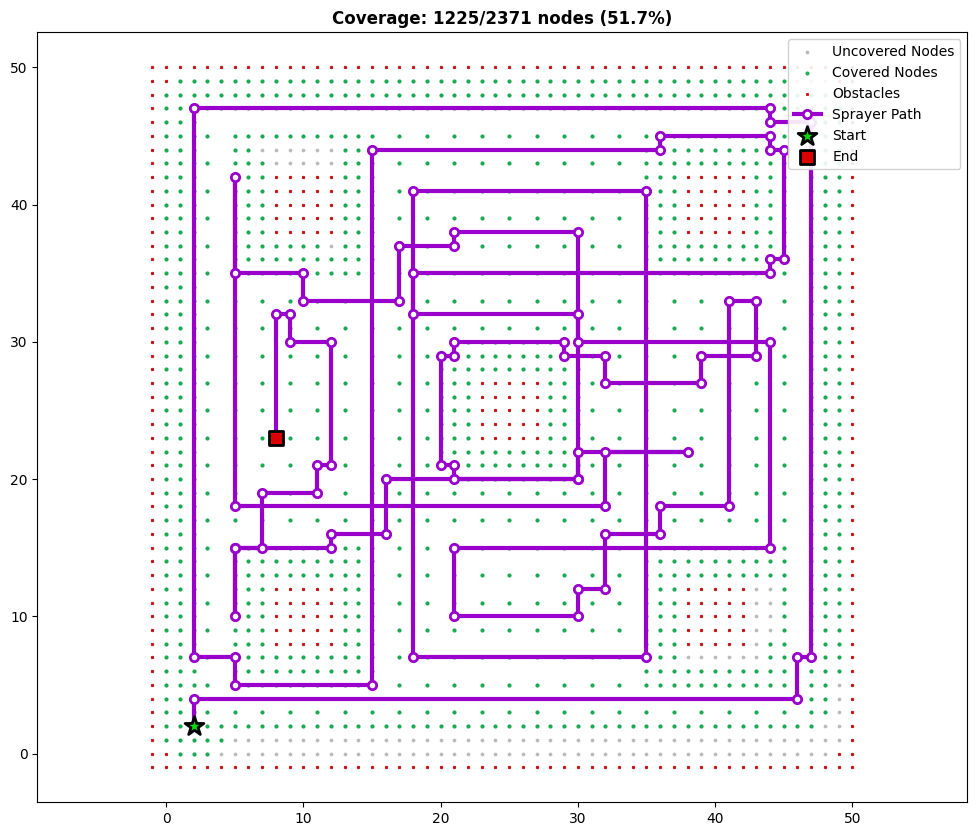

In [6]:
initial_sol = ts._constructive_heuristic(strategy.constructive_heuristic)
display_grid_and_path(instance, evaluator, initial_sol.path)

In [7]:
solution = ts.solve(initial_solution=initial_sol)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 1678.95
-----------------------------------------------------------
Iteration 0: Best ObjFun = 1678.95, Current ObjFun = 1678.95
Applying move: move with args (6, array([44, 47]))
Iteration 1: Best ObjFun = 1675.08, Current ObjFun = 1675.08
Applying move: move with args (1, array([2, 2]))
Iteration 2: Best ObjFun = 1644.38, Current ObjFun = 1644.38
Applying move: insert with args ((np.int64(42), np.int64(5)), 0)

=== Trocando para Fase 2 (Objetivo: Otimizar C2) ===
Iteration 3: Best ObjFun = 1644.38, Current ObjFun = 1680.23
Applying move: move with args (35, array([25,  9]))
Iteration 4: Best ObjFun = 1644.38, Current ObjFun = 1677.38
Applying move: remove with args (21,)
Iteration 5: Best ObjFun = 1644.38, Current ObjFun = 1674.38
Applying move: move with args (44, array([43, 29]))
Iteration 6: Best ObjFun = 1644.38, Current ObjFun = 1669.96
Applyi

Coverage: 1348/2371 nodes (56.9%)
Obstacles: 0/333 covered


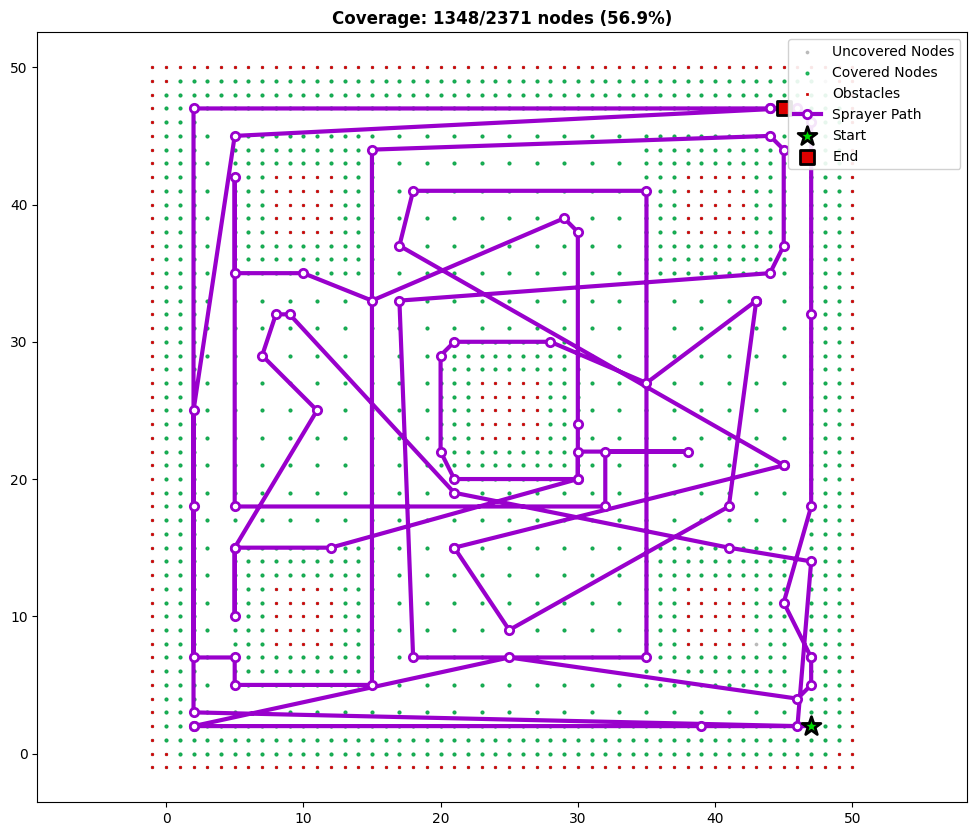

In [8]:
last_solution = ts._current_solution
display_grid_and_path(instance, evaluator, last_solution.path)

In [9]:
solution.cache["hits_obstacle"]

np.False_

In [10]:
strategy = TSStrategy(
    constructive_heuristic=ConstructiveHeuristicType.FSM_COVERAGE_PLANNER,
    phased_optimization=PhasedOptimizationParams(phase_iterations=[10, 5, 2], degradation_tolerances=[0, 0, 0]),
    tabu_radius=3,
    search_strategy='first'
)

term_criteria = TerminationCriteria(max_iterations=50)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

  Visitou (np.int64(2), np.int64(2)), cobriu 7 novos nós. 1723 restantes.
Heurística 'Set Cover': Iniciando. 1723 alvos restantes.
  Visitou (np.int64(4), np.int64(4)), cobriu 14 novos nós. 1709 restantes.
  Visitou (np.int64(7), np.int64(4)), cobriu 13 novos nós. 1696 restantes.
  Visitou (np.int64(10), np.int64(4)), cobriu 12 novos nós. 1684 restantes.
  Visitou (np.int64(13), np.int64(4)), cobriu 13 novos nós. 1671 restantes.
  Visitou (np.int64(16), np.int64(4)), cobriu 15 novos nós. 1656 restantes.
  Visitou (np.int64(19), np.int64(4)), cobriu 15 novos nós. 1641 restantes.
  Visitou (np.int64(22), np.int64(4)), cobriu 15 novos nós. 1626 restantes.
  Visitou (np.int64(25), np.int64(4)), cobriu 15 novos nós. 1611 restantes.
  Visitou (np.int64(28), np.int64(4)), cobriu 15 novos nós. 1596 restantes.
  Visitou (np.int64(31), np.int64(4)), cobriu 15 novos nós. 1581 restantes.
  Visitou (np.int64(34), np.int64(4)), cobriu 15 novos nós. 1566 restantes.
  Visitou (np.int64(37), np.int64(4

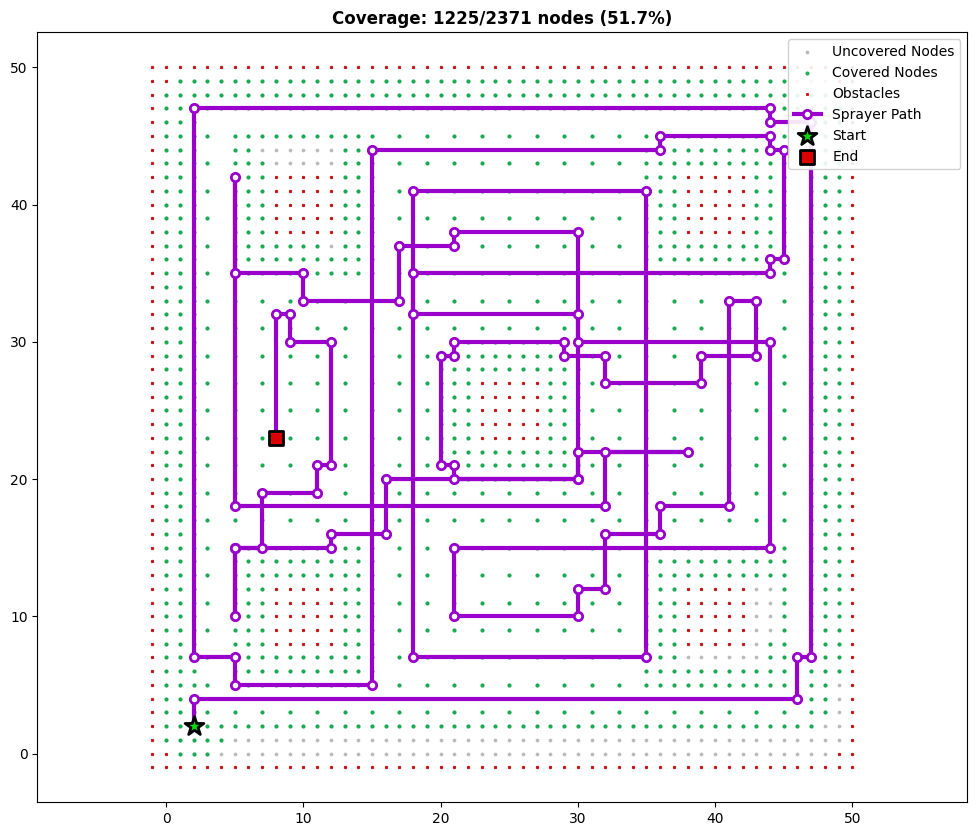

In [11]:
initial_sol = ts._constructive_heuristic(strategy.constructive_heuristic)
display_grid_and_path(instance, evaluator, initial_sol.path)

In [12]:
solution = ts.solve(initial_solution=initial_sol)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 1678.95
-----------------------------------------------------------
Iteration 0: Best ObjFun = 1678.95, Current ObjFun = 1678.95
Applying move: remove with args (1,)
Iteration 1: Best ObjFun = 1648.25, Current ObjFun = 1648.25
Applying move: insert with args ((np.int64(35), np.int64(2)), 88)
Iteration 2: Best ObjFun = 1648.25, Current ObjFun = 1679.29
Applying move: insert with args ((np.int64(45), np.int64(3)), 1)
Iteration 3: Best ObjFun = 1648.25, Current ObjFun = 1669.34
Applying move: insert with args ((np.int64(36), np.int64(5)), 89)
Iteration 4: Best ObjFun = 1648.25, Current ObjFun = 1671.70
Applying move: insert with args ((np.int64(25), np.int64(5)), 91)
Iteration 5: Best ObjFun = 1648.25, Current ObjFun = 1682.40
Applying move: remove with args (6,)
Iteration 6: Best ObjFun = 1648.25, Current ObjFun = 1678.58
Applying move: insert with arg

Coverage: 1348/2371 nodes (56.9%)
Obstacles: 0/333 covered


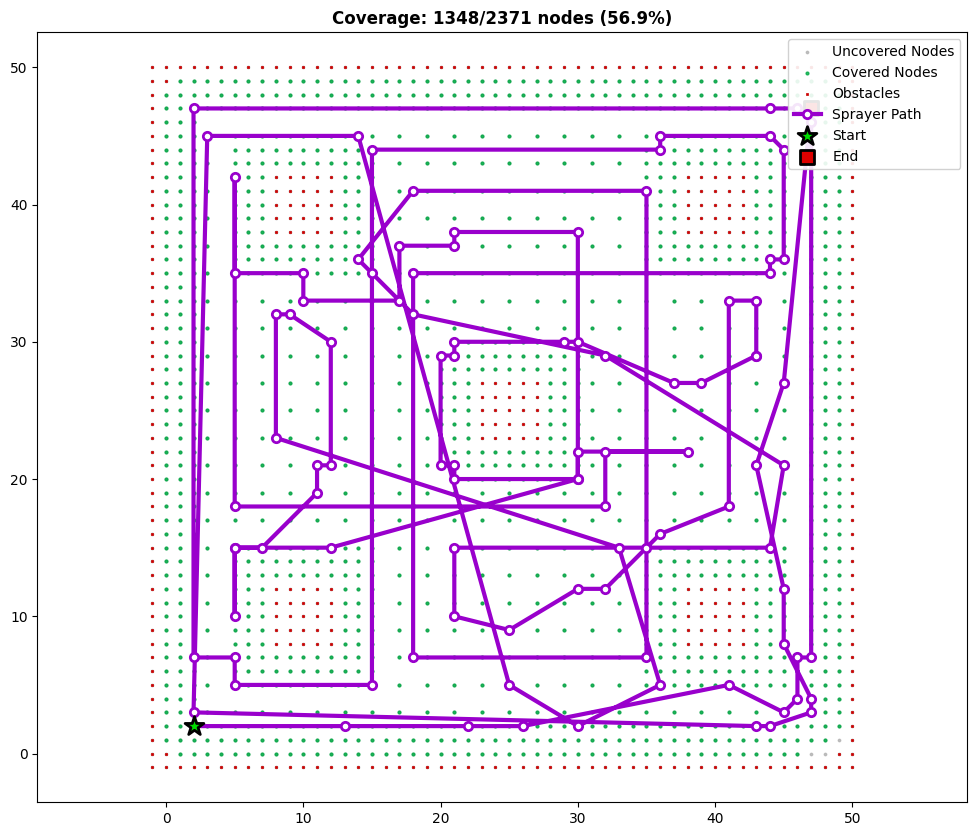

In [13]:
last_solution = ts._current_solution
display_grid_and_path(instance, evaluator, last_solution.path)

In [14]:
strategy = TSStrategy(
    constructive_heuristic=ConstructiveHeuristicType.FSM_COVERAGE_PLANNER,
    phased_optimization=PhasedOptimizationParams(phase_iterations=[5, 5, 2], degradation_tolerances=[0, 0, 0]),
    tabu_radius=3,
    search_strategy='best'
)

term_criteria = TerminationCriteria(max_iterations=200)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

  Visitou (np.int64(2), np.int64(2)), cobriu 7 novos nós. 1723 restantes.
Heurística 'Set Cover': Iniciando. 1723 alvos restantes.
  Visitou (np.int64(4), np.int64(4)), cobriu 14 novos nós. 1709 restantes.
  Visitou (np.int64(7), np.int64(4)), cobriu 13 novos nós. 1696 restantes.
  Visitou (np.int64(10), np.int64(4)), cobriu 12 novos nós. 1684 restantes.
  Visitou (np.int64(13), np.int64(4)), cobriu 13 novos nós. 1671 restantes.
  Visitou (np.int64(16), np.int64(4)), cobriu 15 novos nós. 1656 restantes.
  Visitou (np.int64(19), np.int64(4)), cobriu 15 novos nós. 1641 restantes.
  Visitou (np.int64(22), np.int64(4)), cobriu 15 novos nós. 1626 restantes.
  Visitou (np.int64(25), np.int64(4)), cobriu 15 novos nós. 1611 restantes.
  Visitou (np.int64(28), np.int64(4)), cobriu 15 novos nós. 1596 restantes.
  Visitou (np.int64(31), np.int64(4)), cobriu 15 novos nós. 1581 restantes.
  Visitou (np.int64(34), np.int64(4)), cobriu 15 novos nós. 1566 restantes.
  Visitou (np.int64(37), np.int64(4

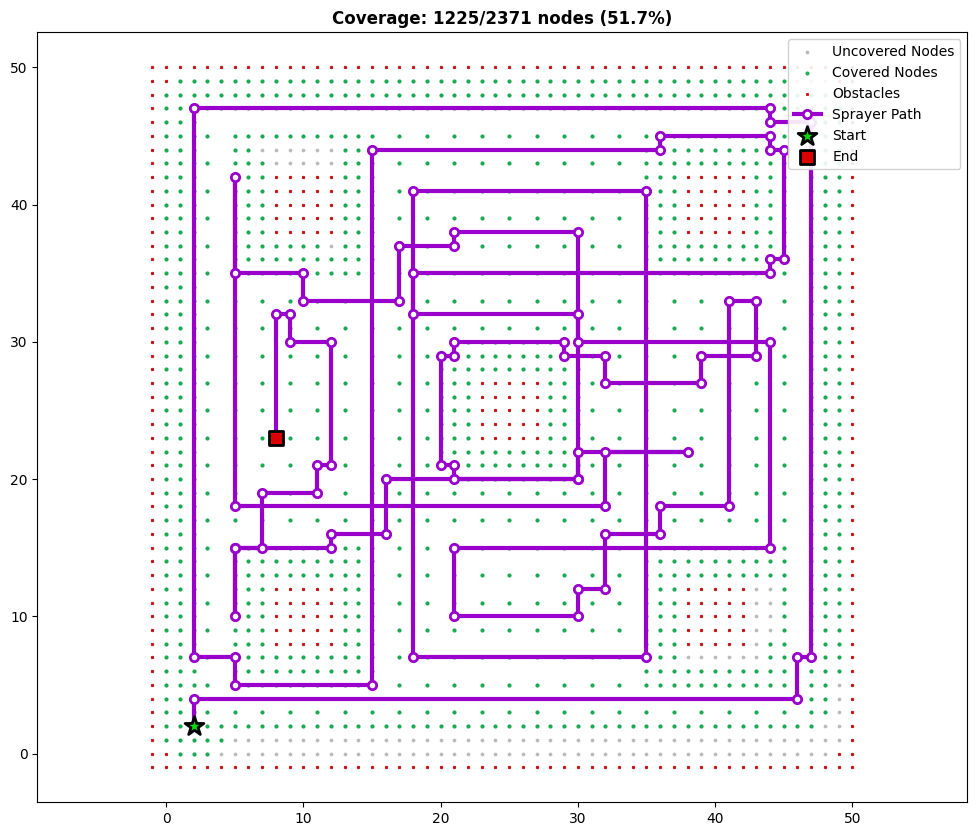

In [15]:
initial_sol = ts._constructive_heuristic(strategy.constructive_heuristic)
display_grid_and_path(instance, evaluator, initial_sol.path)

In [ ]:
solution = ts.solve(initial_solution=initial_sol)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 1678.95
-----------------------------------------------------------
Iteration 0: Best ObjFun = 1678.95, Current ObjFun = 1678.95
** BEST IMPROVING ACEITO ** Tipo: remove, Delta Foco (0): -27.6997
Applying move: remove with args (1,)
Iteration 1: Best ObjFun = 1648.25, Current ObjFun = 1648.25


Coverage: 1334/2371 nodes (56.3%)
Obstacles: 0/333 covered


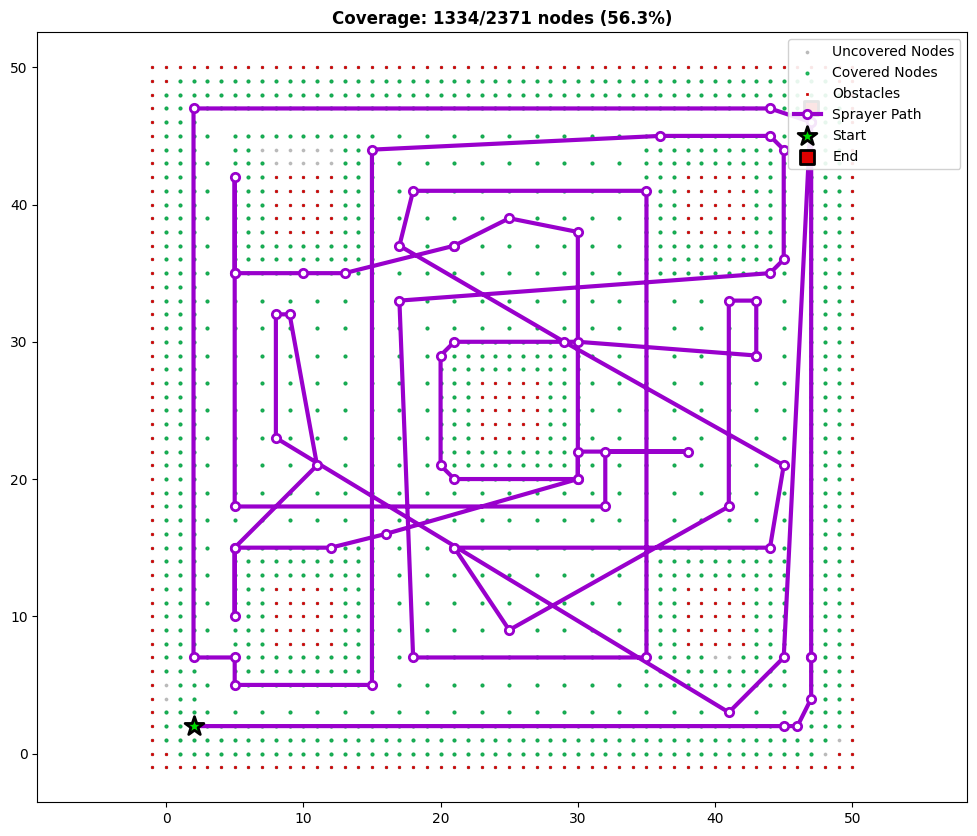

In [ ]:
last_solution = ts._current_solution
display_grid_and_path(instance, evaluator, last_solution.path)